In [18]:
import os, glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback,EarlyStopping
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import  classification_report

In [19]:
file_path = '/kaggle/input/surgery-dataset/dataset'

In [20]:
name_class = os.listdir(file_path)
name_class

['scissor', 'unknown', 'grasper', 'hook', 'no_tool', 'clipper']

In [21]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [22]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

In [23]:

filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head(5)


,Filepath,Label
0,/kaggle/input/surgery-dataset/dataset/clipper/...,clipper
1,/kaggle/input/surgery-dataset/dataset/scissor/...,scissor
2,/kaggle/input/surgery-dataset/dataset/scissor/...,scissor
3,/kaggle/input/surgery-dataset/dataset/no_tool/...,no_tool
4,/kaggle/input/surgery-dataset/dataset/clipper/...,clipper


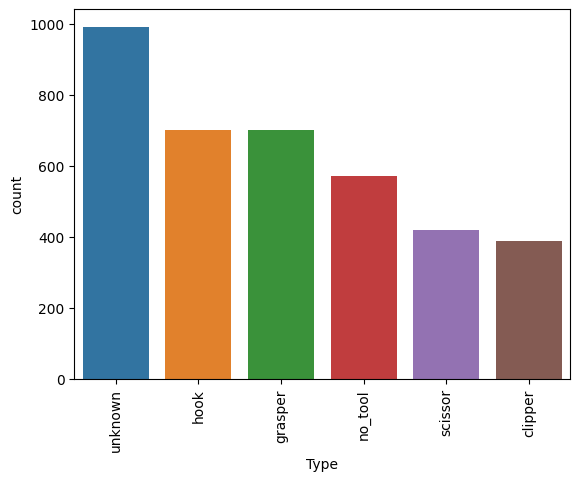

In [24]:
counts = data.Label.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Type')
plt.xticks(rotation=90);

In [25]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

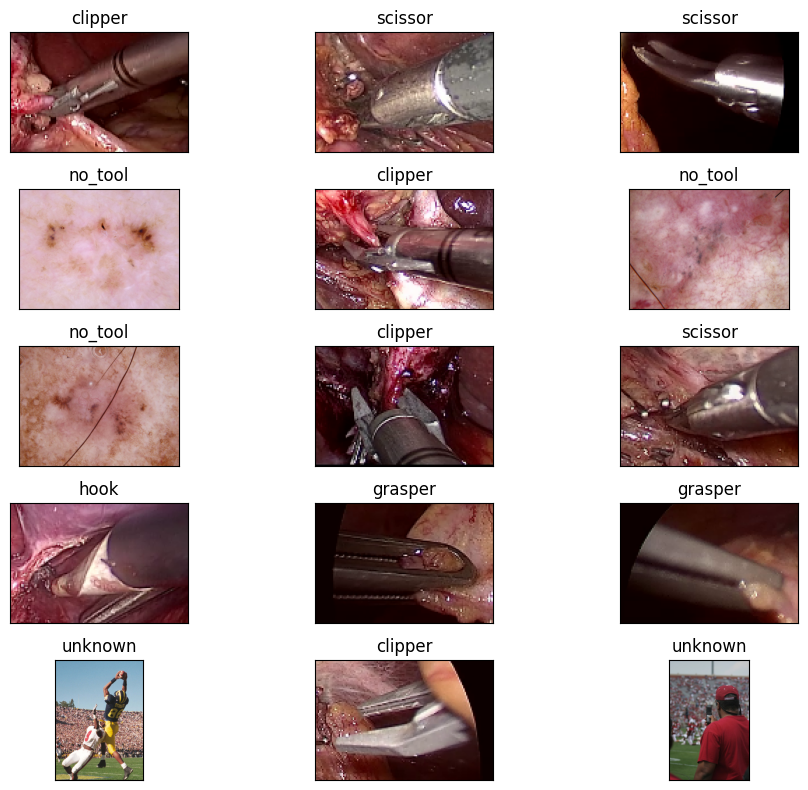

In [26]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(10,8), subplot_kw={'xticks':[],'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.Filepath[i]))
    ax.set_title(data.Label[i])
plt.tight_layout()
plt.show()

In [27]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [28]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 2828 validated image filenames belonging to 6 classes.
Found 943 validated image filenames belonging to 6 classes.
Found 943 validated image filenames belonging to 6 classes.


In [29]:
pretrained_model = ResNet50(
    input_shape=(100,100, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

In [30]:
inputs = pretrained_model.input

x = Dense(128, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(6, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [31]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [32]:
my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [33]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=25
)

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 92s 928ms/step - accuracy: 0.7561 - loss: 0.7129 - val_accuracy: 0.9290 - val_loss: 0.1919
Epoch 2/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 79s 877ms/step - accuracy: 0.9609 - loss: 0.1150 - val_accuracy: 0.9555 - val_loss: 0.1438
Epoch 3/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 79s 874ms/step - accuracy: 0.9822 - loss: 0.0492 - val_accuracy: 0.9555 - val_loss: 0.1645
Epoch 4/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 78s 870ms/step - accuracy: 0.9949 - loss: 0.0189 - val_accuracy: 0.9608 - val_loss: 0.1466
Epoch 5/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 79s 878ms/step - accuracy: 0.9978 - loss: 0.0072 - val_accuracy: 0.9650 - val_loss: 0.1416
Epoch 6/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 81s 871ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.9608 - val_loss: 0.1520
Epoch 7/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 79s 877ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9650 - val_loss: 0.1471
Epoch 8/25
89/89 ━━━━━━━━━━━━━━━━━━━━ 78s 869ms/step - accuracy: 1.0000 - loss: 8.2568e-04 - val_accuracy: 0

In [34]:
model.save("/kaggle/working/surgical_detection_model.h5")

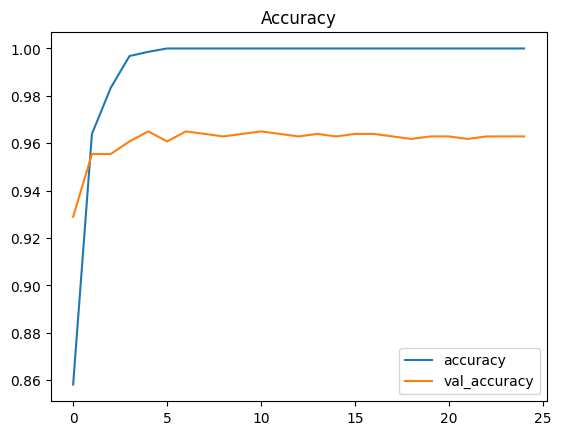

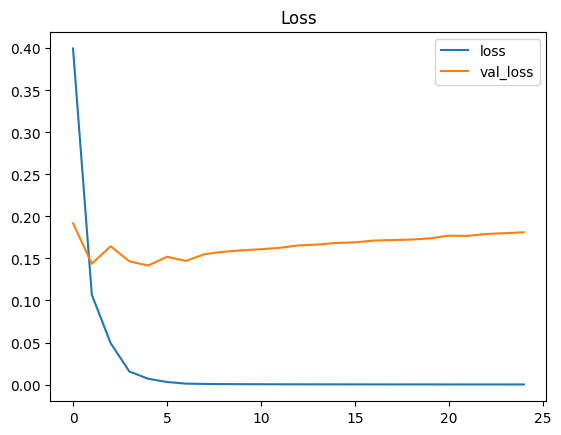

In [35]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [36]:
results = model.evaluate(test_gen, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


    Test Loss: 0.18109
Test Accuracy: 96.29%


In [37]:
# Predict the label of the test_gen
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 689ms/step


In [38]:
y_test = list(test.Label)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

     clipper       0.91      0.89      0.90       100
     grasper       0.97      0.94      0.95       170
        hook       0.93      0.96      0.94       170
     no_tool       1.00      1.00      1.00       132
     scissor       0.92      0.95      0.93       110
     unknown       1.00      1.00      1.00       261

    accuracy                           0.96       943
   macro avg       0.95      0.95      0.95       943
weighted avg       0.96      0.96      0.96       943



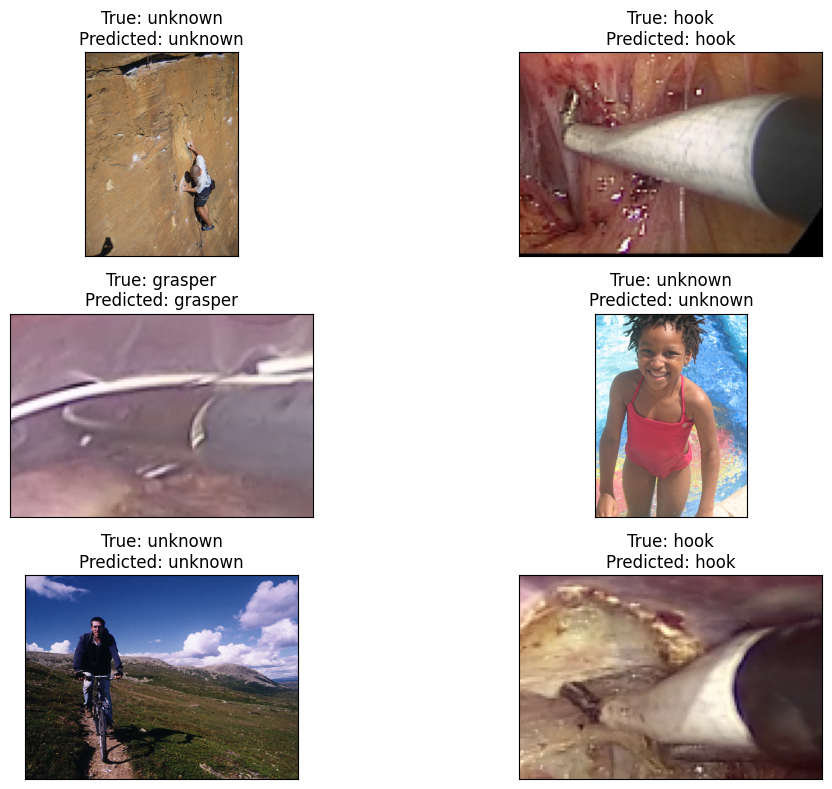

In [39]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [40]:
import cv2
import numpy as np
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input

img_path = '/kaggle/input/surgery-dataset/dataset/grasper/7013_10026.png'

#img = image.load_img(img_path, target_size=(224, 224))
#x = img.img_to_array(img)

img = cv2.imread(img_path)
img = cv2.resize(img, (100, 100))

x = np.expand_dims(img, axis=0)
x = preprocess_input(x)
result = model.predict(x)
print((result*100).astype('int'))

#print('Input image shape:', x.shape)

#my_image = imread(img_path)
#imshow(my_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[ 0 99  0  0  0  0]]


In [41]:
from tensorflow.keras.models import load_model
loaded_model_imageNet = load_model("/kaggle/working/surgical_detection_model.h5")
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

In [42]:
import cv2
import numpy as np
from matplotlib.pyplot import imread
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras.applications.imagenet_utils import preprocess_input

img_path = '/kaggle/input/surgery-dataset/dataset/grasper/7013_10026.png'

#img = image.load_img(img_path, target_size=(224, 224))
#x = img.img_to_array(img)

img = cv2.imread(img_path)
img = cv2.resize(img, (100, 100))

x = np.expand_dims(img, axis=0)
x = preprocess_input(x)
result = loaded_model_imageNet.predict(x)
print((result*100).astype('int'))

#print('Input image shape:', x.shape)

#my_image = imread(img_path)
#imshow(my_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[[ 0 99  0  0  0  0]]


In [43]:
p=list((result*100).astype('int'))
pp=list(p[0])
print(pp)

[0, 99, 0, 0, 0, 0]


In [44]:
print("Largest element is:", max(pp))

Largest element is: 99


In [45]:
index = pp.index(max(pp))

In [46]:
name_class=['scissor', 'unknown', 'grasper', 'hook', 'no_tool', 'clipper']

In [47]:
import matplotlib.pyplot as plt

In [48]:
plt.imread(img_path)

array([[[0.00392157, 0.        , 0.        ],
        [0.00392157, 0.        , 0.        ],
        [0.00392157, 0.        , 0.        ],
        ...,
        [0.6784314 , 0.49019608, 0.41960785],
        [0.6784314 , 0.49019608, 0.41568628],
        [0.6784314 , 0.49411765, 0.40784314]],

       [[0.00392157, 0.        , 0.        ],
        [0.00392157, 0.        , 0.        ],
        [0.00392157, 0.        , 0.        ],
        ...,
        [0.6745098 , 0.49019608, 0.41960785],
        [0.6666667 , 0.4862745 , 0.4117647 ],
        [0.6627451 , 0.48235294, 0.40784314]],

       [[0.00392157, 0.        , 0.        ],
        [0.00392157, 0.        , 0.        ],
        [0.00392157, 0.        , 0.        ],
        ...,
        [0.65882355, 0.47843137, 0.40784314],
        [0.654902  , 0.4745098 , 0.40392157],
        [0.6509804 , 0.47058824, 0.4       ]],

       ...,

       [[0.00392157, 0.        , 0.        ],
        [0.00392157, 0.        , 0.        ],
        [0.00784314, 0

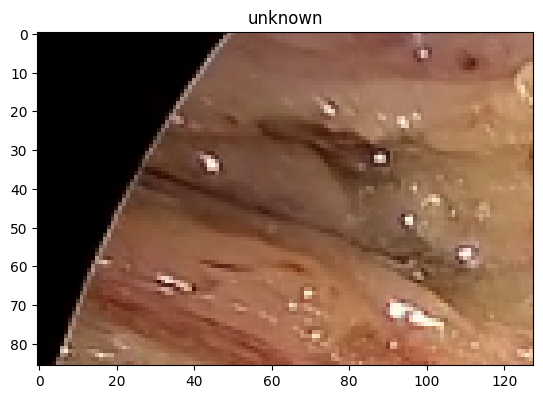

In [49]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.title(name_class[index])
plt.show()

In [50]:
import requests

# Define the file path
file_path = '/kaggle/working/surgical_detection_model.h5'

# Open the file and upload to File.io
with open(file_path, 'rb') as file:
    response = requests.post(
        'https://file.io', 
        files={'file': file}
    )

# Check if the upload was successful and get the download link
if response.status_code == 200:
    download_link = response.json()['link']
    print("File successfully uploaded. Download link:")
    print(download_link)
else:
    print("File upload failed.")


File successfully uploaded. Download link:
https://file.io/c7Es8y3T0bj2


In [1]:
!python --version

Python 3.10.14


In [2]:
!pip freeze

absl-py==1.4.0
accelerate==0.34.2
aiobotocore==2.15.1
aiofiles==22.1.0
aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1713964853148/work
aioitertools==0.12.0
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1667935791922/work
aiosqlite==0.20.0
albucore==0.0.17
albumentations==1.4.17
alembic==1.13.3
altair==5.4.1
annotated-types==0.7.0
annoy==1.17.3
ansicolors==1.1.8
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1717693030552/work
apache-beam==2.46.0
appdirs==1.4.4
archspec @ file:///home/conda/feedstock_root/build_artifacts/archspec_1708969572489/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1692818318753/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1695386546427/work
array_record==0.5.1
arrow @ file:///home/conda/feedstock_root/build_artifacts/arrow_1696128962909/work
arviz==0.20.0
astroid==3.3.4
asttokens @ file:///home/conda/feedstock